<a href="https://colab.research.google.com/github/vineetsarpal/fender-bender-ai-train/blob/main/FenderBenderAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fender Bender AI

## Phase 1: Exploratory Data Analysis (EDA)

**Objective:** This project aims to develop a robust computer vision model using the **YOLOv11** architecture to automate the detection and classification of vehicular damage. Automated inspection reduces subjectivity in insurance claims and provides immediate repair estimates for users.

**Data Source:**
We are utilizing the [Automobile Damage Detection Dataset](https://universe.roboflow.com/automobile-damage-detection/automobile-damage-detection) from Roboflow Universe. This dataset consists of ~6,900 images across 14 distinct damage categories, ranging from minor scratches to severe structural dents.

**Phase 1 Focus:**
Before training, we must audit the dataset to understand:
1. **Class Distribution:** Are some damage types overrepresented (e.g., dents vs. broken glass)?
2. **Annotation Integrity:** Are the bounding boxes accurately localized on the damaged regions?
3. **Data Quality:** Are the images diverse in terms of lighting, angles, and vehicle types?

### 1. Environment Setup & Data Acquisition

In [ ]:
!pip install -q roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.7 MB/s eta 0:00:00


In [ ]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from roboflow import Roboflow

In [ ]:
from google.colab import userdata

RF_API_KEY = userdata.get('RF_API_KEY')

In [ ]:
# Initialize Roboflow and download the dataset
rf = Roboflow(api_key=RF_API_KEY)
project = rf.workspace("automobile-damage-detection").project("automobile-damage-detection")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Automobile-Damage-Detection-4 in yolov11:: 100%|██████████| 13926/13926 [00:02<00:00, 4982.33it/s]


In [ ]:
# Load dataset metadata
with open(f"{dataset.location}/data.yaml", 'r') as f:
    data_info = yaml.safe_load(f)

class_names = data_info['names']
print(f"Detected Classes: {class_names}")

Detected Classes: ['Front-windscreen-damage', 'Headlight-damage', 'Rear-windscreen-Damage', 'Runningboard-Damage', 'Sidemirror-Damage', 'Taillight-Damage', 'bonnet-dent', 'boot-dent', 'doorouter-dent', 'fender-dent', 'front-bumper-dent', 'quaterpanel-dent', 'rear-bumper-dent', 'roof-dent']


### 2. Class Distribution Analysis
A critical challenge in car damage detection is **Class Imbalance**. In real-world scenarios, scratches are more common than total-loss structural damage.

If the model is trained on imbalanced data, it may develop a bias toward the majority class (e.g., predicting every defect as a 'dent'). We will now calculate and visualize the frequency of each class in the training split to identify if any **data augmentation** or **resampling** strategies will be necessary.

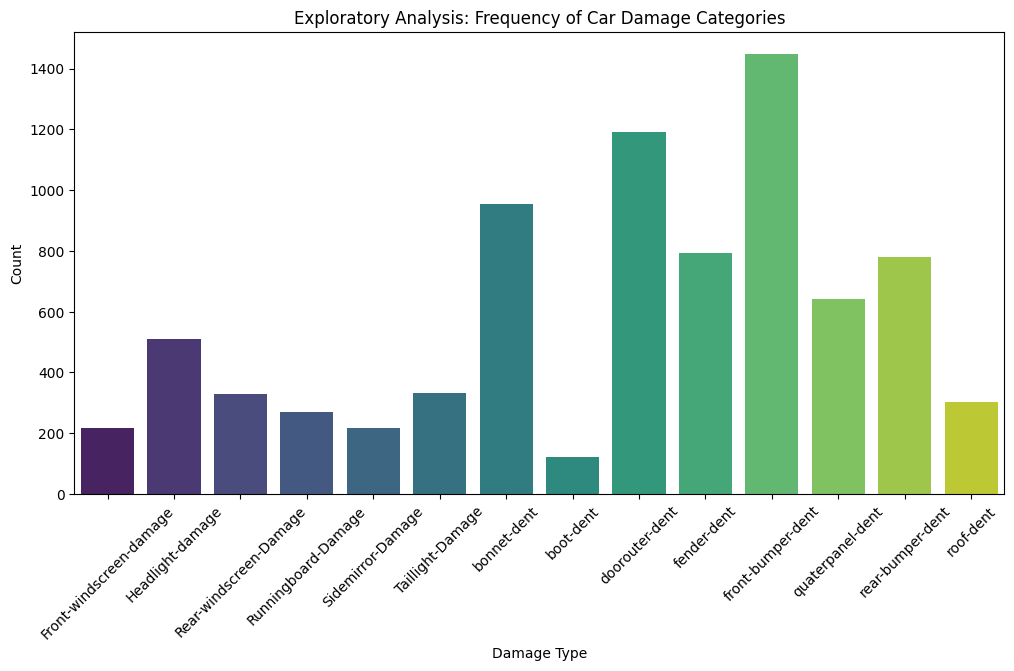

In [ ]:
def get_label_stats(split='train'):
    label_path = os.path.join(dataset.location, split, 'labels')
    stats = {name: 0 for name in class_names}

    for label_file in os.listdir(label_path):
        with open(os.path.join(label_path, label_file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                stats[class_names[class_id]] += 1
    return stats

# Analyze the training split
train_stats = get_label_stats('train')
df_stats = pd.DataFrame(list(train_stats.items()), columns=['Damage Type', 'Count'])

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=df_stats, x='Damage Type', y='Count', hue='Damage Type', palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Exploratory Analysis: Frequency of Car Damage Categories')
plt.show()

### 3. Ground Truth Verification
To ensure the model learns correctly, we must verify the "Ground Truth" labels. Object detection models rely on the precise intersection-over-union ($IoU$) of predicted boxes and these human-annotated boxes.

In this section, we randomly sample images from the training set and overlay the bounding boxes. We are looking for:
* **Localization Accuracy:** Does the box tightly hug the damage?
* **Multi-label Presence:** Can the model see a "dent" and a "scratch" occurring on the same panel?

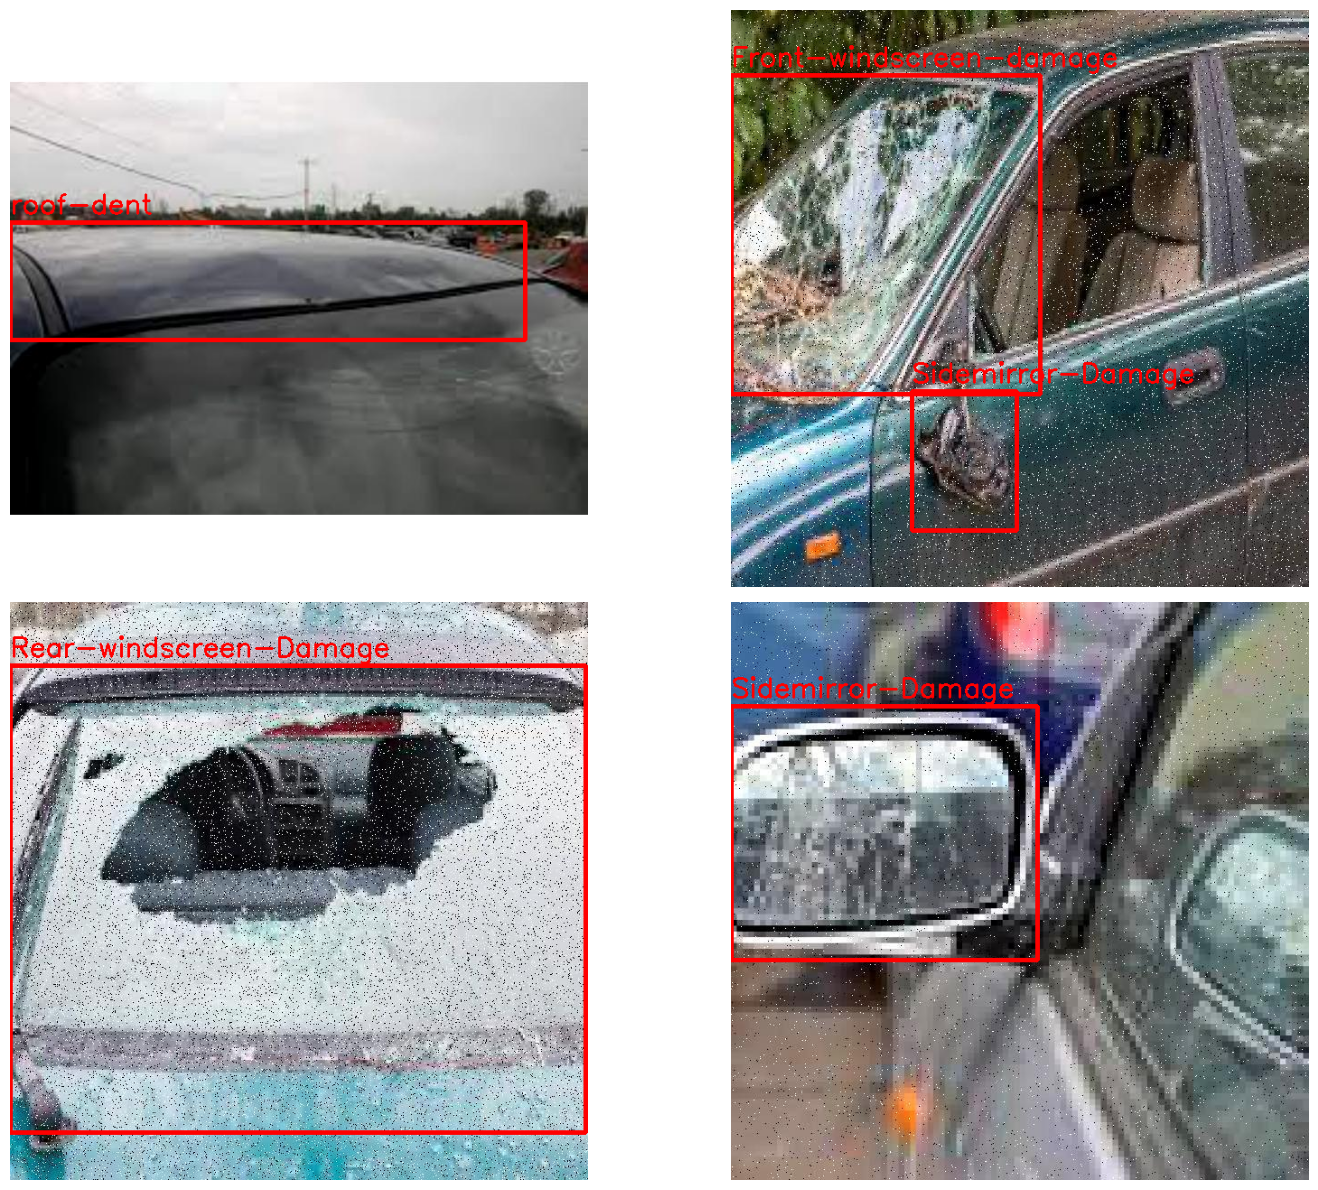

In [ ]:
import cv2
import numpy as np

def visualize_samples(num_samples=4):
    img_dir = os.path.join(dataset.location, 'train', 'images')
    lbl_dir = os.path.join(dataset.location, 'train', 'labels')
    images = os.listdir(img_dir)[:num_samples]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Read label
        with open(os.path.join(lbl_dir, img_name.replace('.jpg', '.txt')), 'r') as f:
            for line in f:
                cls, x, y, nw, nh = map(float, line.split())
                # Denormalize
                x1, y1 = int((x - nw/2) * w), int((y - nh/2) * h)
                x2, y2 = int((x + nw/2) * w), int((y + nh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
                cv2.putText(img, class_names[int(cls)], (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        ax = axes[i//2, i%2]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

visualize_samples()

### 4. EDA Synthesis & Research Summary
Based on the visual and statistical evidence gathered above, we can conclude the following about our dataset:
* **Class Balance:** The dataset is relatively balanced, though "boot-dent" is a minority class.
* **Image Diversity:** The dataset includes various car makes and lighting conditions, which should support model **generalization**.


With the data audited, we will proceed to **Model Training**. We will employ YOLOv11-Nano to balance computational efficiency on shared hardware with the high-precision requirements of damage classification.

## Phase 2: Model Training & Hyperparameter Selection

**Objective:** In this phase, we fine-tune a pre-trained **YOLOv11-Nano** model on our car damage dataset. Fine-tuning allows the model to leverage general visual features (like edges and shapes) learned from the dataset while specializing in the unique textures of vehicular damage.

#### Research Hyperparameters:
For this experiment, we have selected the following settings:
* **Model:** `yolo11n.pt` (Nano). We chose the smallest variant to ensure high inference speeds for the real-time Hugging Face demo.
* **Image Size (`imgsz`):** `640`. Standard for YOLO, providing a balance between detecting fine scratches and maintaining memory efficiency.
* **Epochs:** `50`. Sufficient for a dataset of this size to reach convergence without significant overfitting.
* **Batch Size:** `16`. Chosen to fit within the 16GB VRAM of the Google Colab T4 GPU.
* **Device:** `0` (CUDA). Leveraging NVIDIA GPU acceleration.

#### Implementation:
We use the `ultralytics` framework's `train` mode, which automatically handles the learning rate schedule and data augmentation (Mosaic, HSV flippping) to improve model robustness.

### Restoring Previous Research from Google Drive
Below codeblock handles the restoration of previously saved training results and artifacts from Google Drive to the current Colab environment. This ensures that if the Colab runtime disconnects or restarts, any prior progress (like trained model weights, plots, and logs) can be recovered, allowing for seamless continuation of the project without re-running long training processes.

In [ ]:
from google.colab import drive
import os
import shutil

# Mount your Google Drive
drive.mount('/content/drive')

# Define the paths
source_drive_path = "/content/drive/MyDrive/Projects/AutoDamageAssessAI/CarDamageResearch"
destination_local_path = "/content/CarDamageResearch"

# Check if the folder exists in Drive before attempting to copy
if os.path.exists(source_drive_path):
    print(f"Found existing research folder in Drive at: {source_drive_path}")
    # Remove existing local folder if it exists to ensure a clean copy
    if os.path.exists(destination_local_path):
        print(f"Removing existing local research folder: {destination_local_path}")
        shutil.rmtree(destination_local_path)

    print(f"Copying research folder from Drive to local: {destination_local_path}")
    shutil.copytree(source_drive_path, destination_local_path)
    print("✅ Research folder successfully restored from Google Drive!")
elif os.path.exists(destination_local_path):
    print(f"Local research folder already exists at: {destination_local_path}. No need to restore from Drive.")
else:
    print(f"No existing research folder found in Drive at {source_drive_path} or locally at {destination_local_path}. Proceeding without restoring previous results.")

In [ ]:
### 1. Training Execution

In [ ]:
from ultralytics import YOLO
import os

# Define the project and run name to construct the path to the best weights
project_name = 'CarDamageResearch'
run_name = 'v11_nano_base'
model_path = os.path.join('/content', project_name, run_name, 'weights', 'best.pt')

# 1. Conditionally load the pre-trained YOLOv11-Nano weights or resume training
if os.path.exists(model_path):
    print(f"Found existing model weights at {model_path}. Loading model...")
    model = YOLO(model_path)
    print("Model loaded successfully. Skipping training.")
    results = None # No new training results
else:
    print("No existing model weights found. Starting training...")
    model = YOLO('yolo11n.pt') # Load base YOLOv11-Nano weights

    # 2. Begin training
    results = model.train(
        data=f"{dataset.location}/data.yaml",
        epochs=50,
        imgsz=640,
        batch=16,
        patience=10,        # Early stopping: stops if no improvement in 10 epochs
        device=0,           # Use GPU
        project=project_name,
        name=run_name,
        plots=True
    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Automobile-Damage-Detection-4/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False,

### 2. Monitoring the Training Process
While the model trains, we monitor three primary metrics to judge research success:
1.  **Box Loss:** How accurately the model localizes the damage.
2.  **Class Loss:** How accurately it identifies the *type* of damage (e.g., dent vs. scratch).
3.  **mAP@50:** Mean Average Precision at an $IoU$ of 0.5. This is the standard "score" for object detection research.

**Persistence:**
The model automatically saves the best-performing weights as `best.pt`. We will export this file for use in our final Hugging Face Space.

In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount your Google Drive
drive.mount('/content/drive')

# Define the destination path
destination_path = '/content/drive/MyDrive/Projects/AutoDamageAssessAI/CarDamageResearch'

# 2. Check if the permanent folder exists and remove it if it does
if os.path.exists(destination_path):
    print(f"Removing existing directory: {destination_path}")
    shutil.rmtree(destination_path)
    print("Existing directory removed.")

# 3. Copy your entire research folder to Drive
# This ensures all weights (best.pt, last.pt) and charts are safe
shutil.copytree('/content/CarDamageResearch', destination_path)

print("✅ Research folder successfully backed up to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Removing existing directory: /content/drive/MyDrive/Projects/AutoDamageAssessAI/CarDamageResearch
Existing directory removed.
✅ Research folder successfully backed up to Google Drive!


## Phase 3: Research Evaluation & Metrics Analysis

**Objective:** To quantitatively and qualitatively assess the performance of our trained YOLOv11-Nano model. We evaluate the model's ability to localize and classify 14 types of car damage using standardized computer vision benchmarks.

### Primary Metrics for Research:
1.  **mAP@50 (Mean Average Precision):** Measures the overall accuracy of detections at a 50% Intersection-over-Union ($IoU$) threshold.
2.  **Box Loss:** Measures how well the predicted bounding boxes overlap with the ground truth damage.
3.  **Confusion Matrix:** Identifies "inter-class confusion"—for example, whether the model frequently misidentifies a `dent` as a `scratch`.

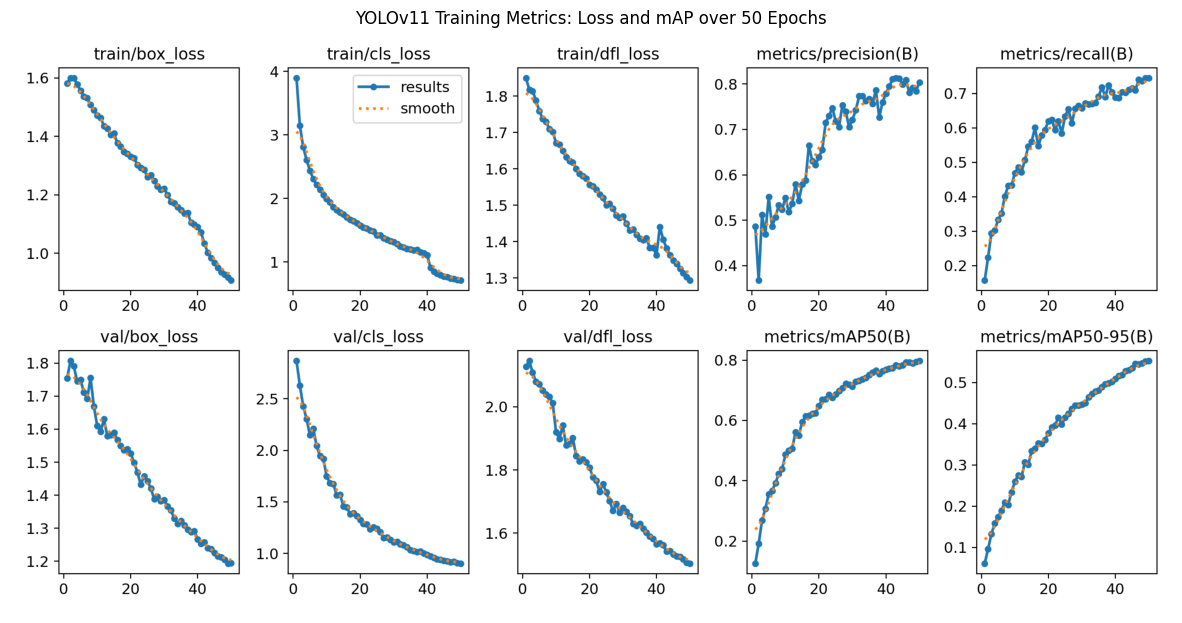

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Path to your research results
results_path = '/content/CarDamageResearch/v11_nano_base/results.png'

if os.path.exists(results_path):
    plt.figure(figsize=(15, 10))
    img = cv2.imread(results_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLOv11 Training Metrics: Loss and mAP over 50 Epochs')
    plt.show()
else:
    print("Results plot not found. Ensure the path matches your training project name.")

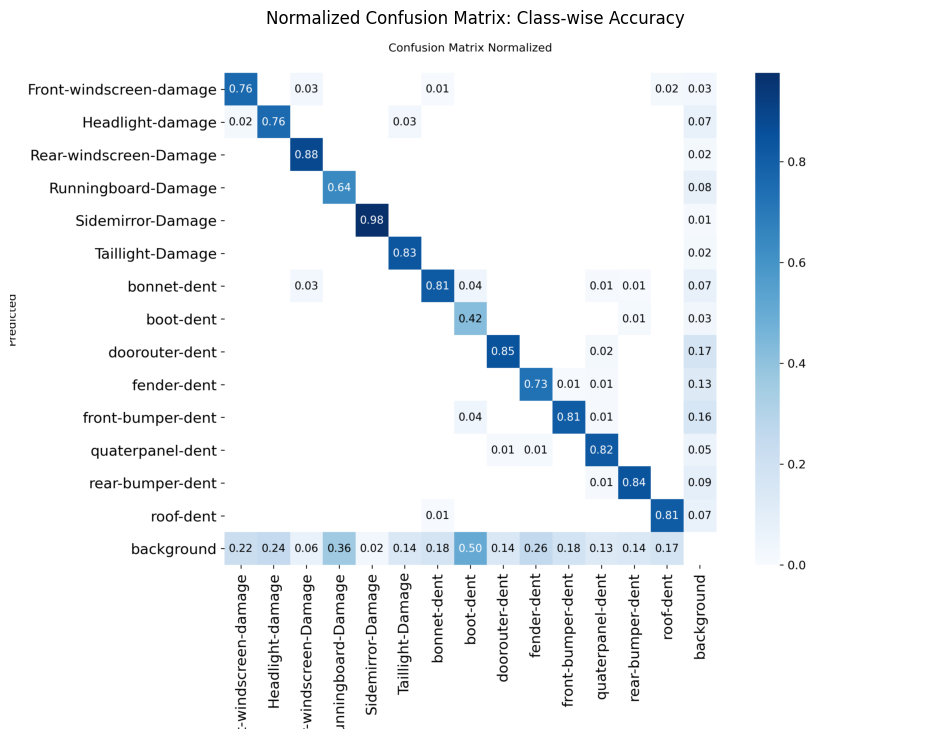

In [ ]:
cm_path = '/content/CarDamageResearch/v11_nano_base/confusion_matrix_normalized.png'

if os.path.exists(cm_path):
    plt.figure(figsize=(12, 10))
    img = cv2.imread(cm_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Normalized Confusion Matrix: Class-wise Accuracy')
    plt.show()